In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16,8)
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error

In [115]:
# Функция для визуального сравнения раельных значений с предсказанными
def visualize(df1, df2, label):
    with plt.style.context('bmh'):
        plt.plot(df1, color='blue',label='original')
        plt.plot(df2, color='red', linewidth='2', label=label)
        plt.legend()

In [5]:
# Отрисовка точек для определения сезонности
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')
        plt.show()

In [6]:
# Проверка ряда на стационарность через тест Дики-Фуллера
def get_diki_fuller_stats(ts):
    stats = adfuller(ts)
    print('ADF Statistic: %f' % stats[0])
    print('p-value: %f' % stats[1])
    print('Lags Used: %f' % stats[2])
    print('Critical Values:')
    for key, value in stats[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n') 

In [7]:
# Вывод графиков исторических данных, а также автокорелляции и частной автокорелляции
def tsplot(y, title, lags=None, style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original ' + title)
    
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

In [110]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    result.append(alpha * series[len(series) - 1] + (1 - alpha) * result[-1])

    for _ in range(n_pred - 1):
        result.append(result[-1])
    
    return pd.Series(result[1:])

In [9]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
airlines_passengers = airlines_passengers['Count']

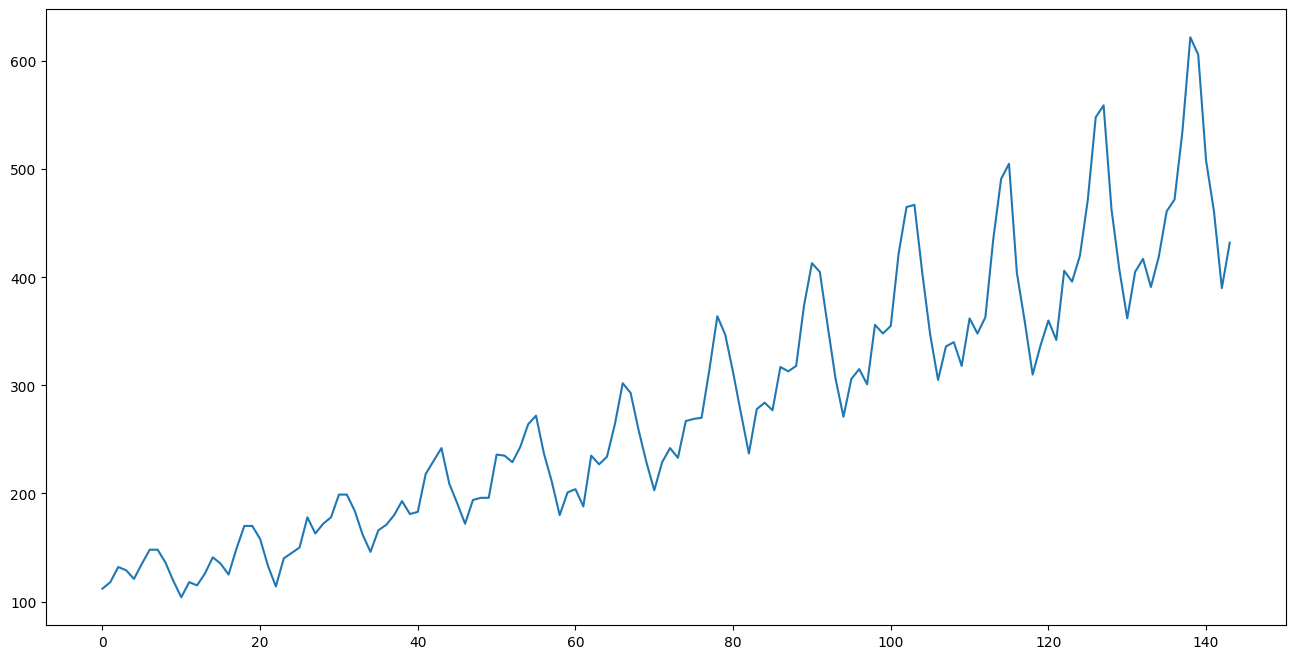

In [10]:
plt.plot(airlines_passengers)

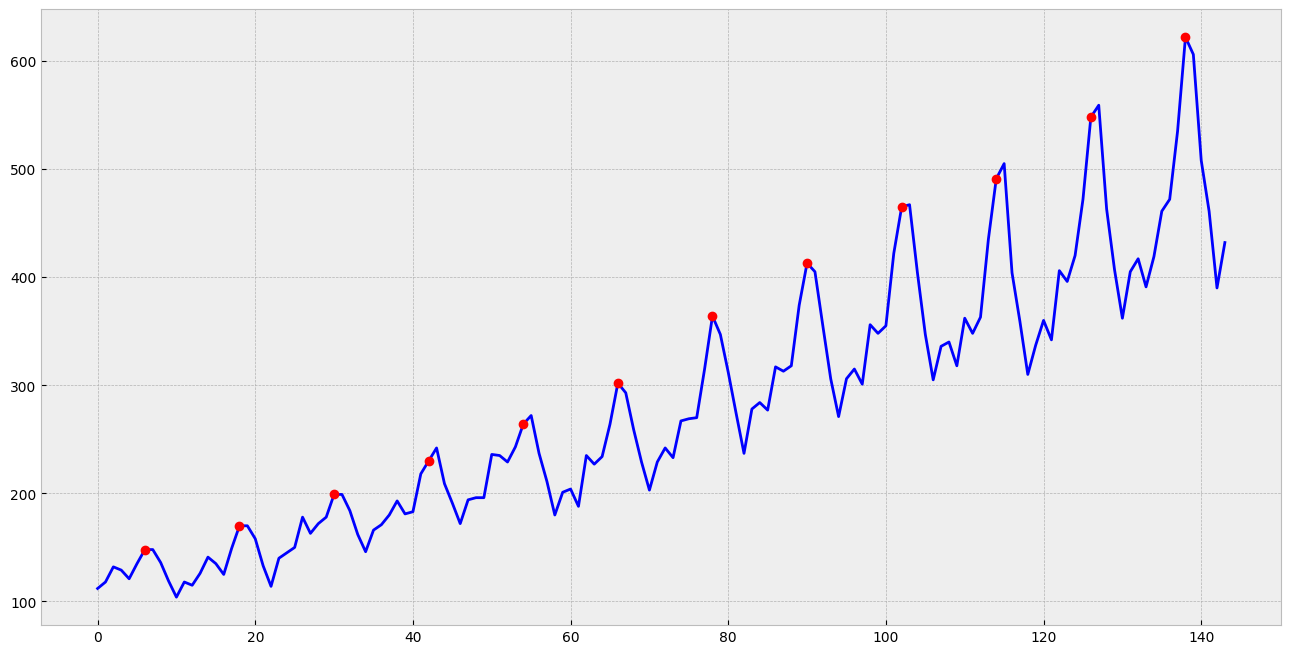

In [11]:
plot_ts_and_points(airlines_passengers, 6, 12)

На графике выше видны четкая сезонность с периодом 12 мес., а также тренд.  
Поэтому считаю логичным использовать тройное экспоненциальное сглаживание.

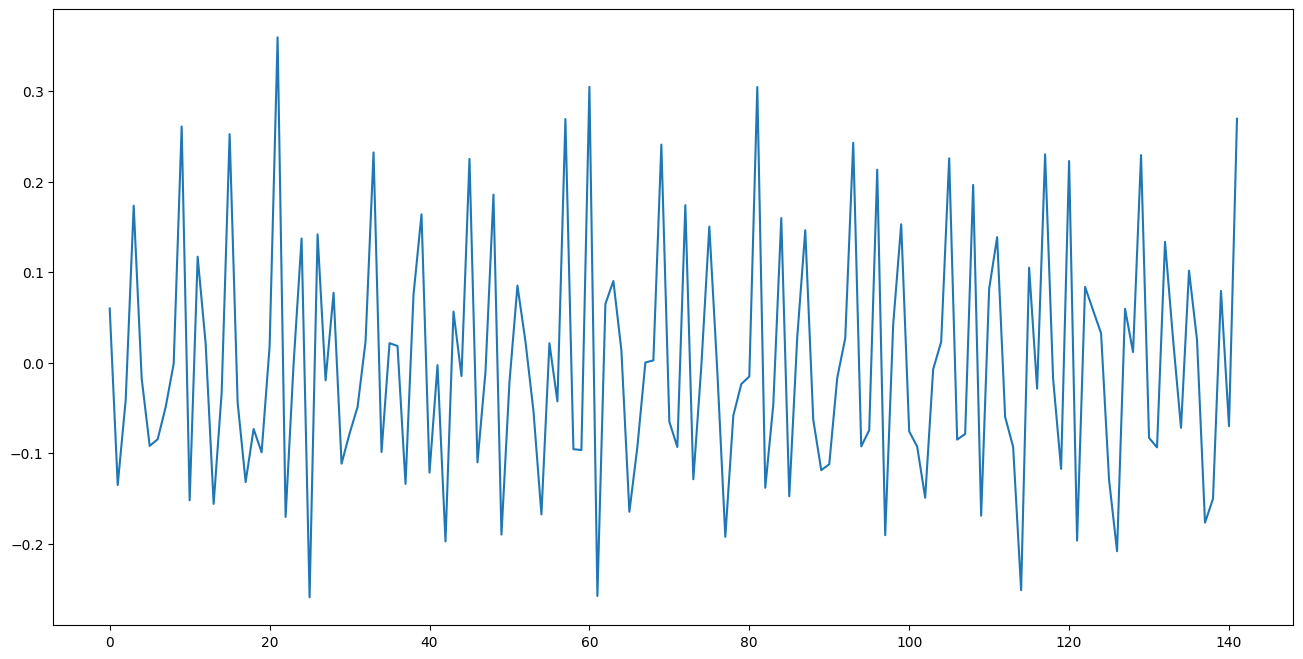

In [12]:
# Преобразуем ряд к стационарному
norm_d_airline = boxcox(airlines_passengers, 0)
diff_airline = np.diff(norm_d_airline, 2)
plt.plot(diff_airline)

In [13]:
get_diki_fuller_stats(diff_airline)

ADF Statistic: -8.196629
p-value: 0.000000
Lags Used: 13.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579




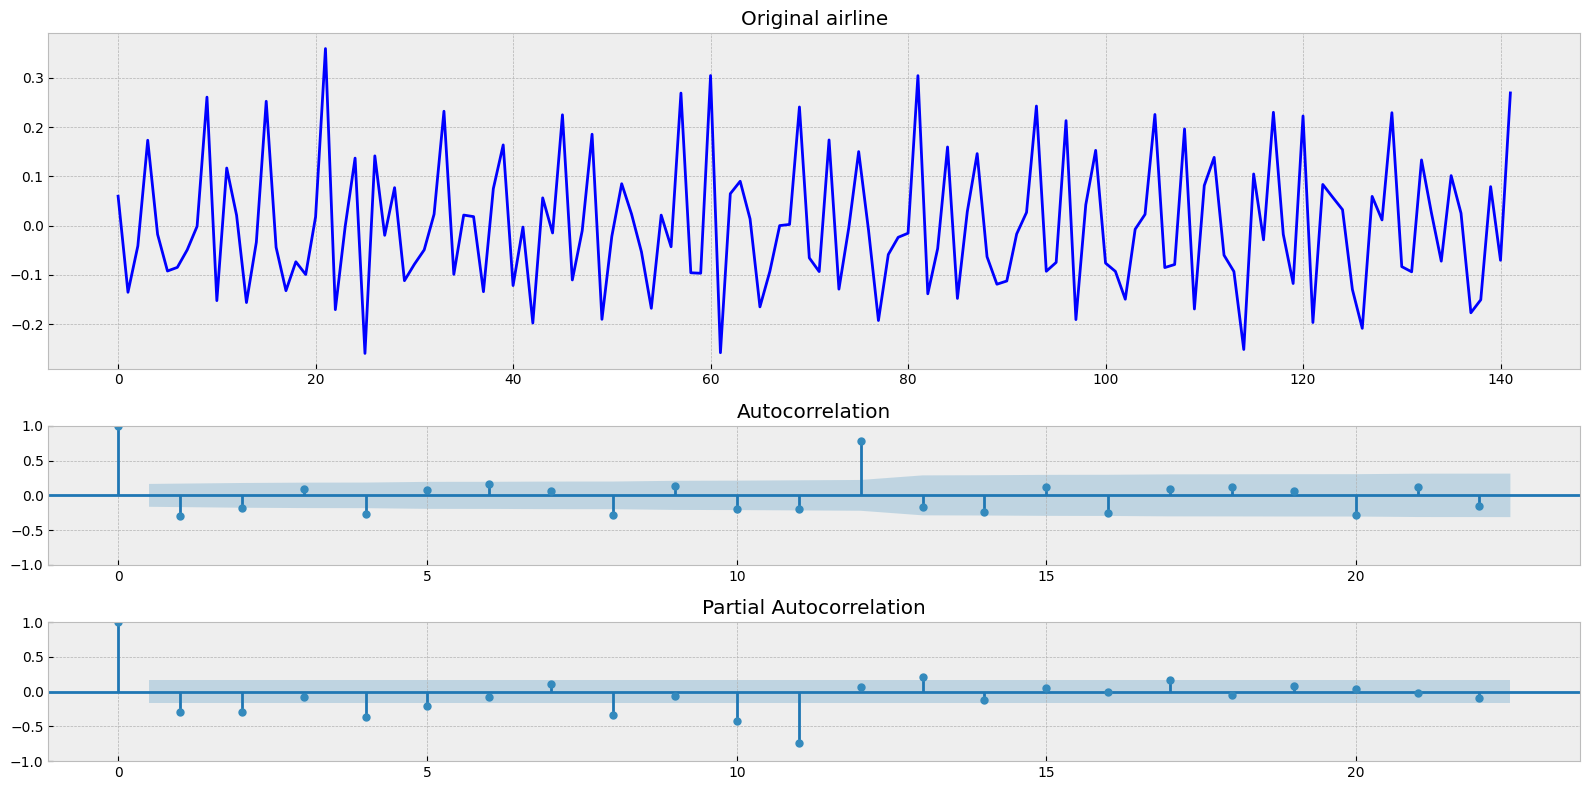

In [14]:
tsplot(diff_airline, 'airline')

# Исторический график

In [15]:
smoothed_airline = ExponentialSmoothing(airlines_passengers, trend='add', seasonal='mul', seasonal_periods=12, damped_trend=True).fit()

In [26]:
fitted = smoothed_airline.predict(0, len(airlines_passengers) + 12)

In [27]:
# Прогноз на следующий период
fitted[len(airlines_passengers): len(airlines_passengers) + 12]

144    445.189893
145    417.964114
146    465.207179
147    494.494796
148    505.318607
149    573.376035
150    663.834023
151    655.625614
152    547.492808
153    489.098215
154    416.269238
155    460.777421
dtype: float64

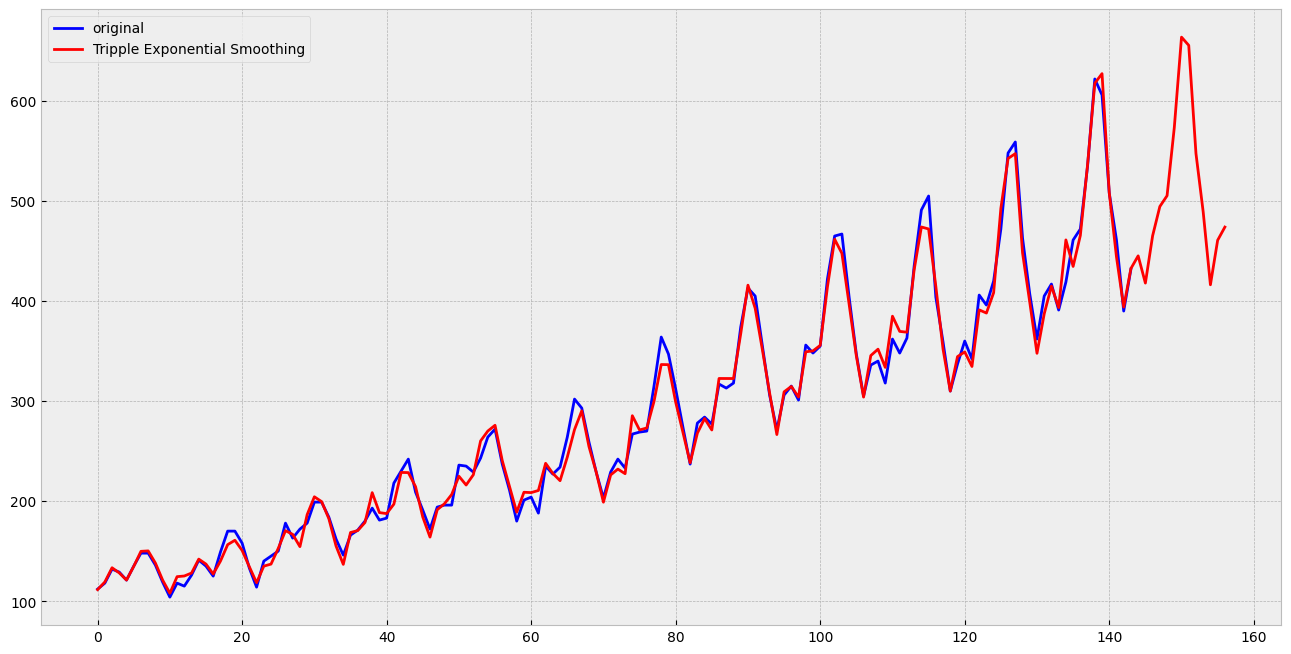

In [116]:
visualize(airlines_passengers, fitted, 'Tripple Exponential Smoothing')

Как видно ряд, полученный из прогноза очень схож и историческим, что говорит о неплохо обученной модели. Теперь используем метрику RMSE 

In [19]:
mean_absolute_error(airlines_passengers, fitted[:len(airlines_passengers)])

7.877124933928041

MAE показал неплохой результат с разбросом в +- 8 тыс. человек, что не особо отразиться на графике => наша модель прогназирования достаточно точна

# Стационарный график

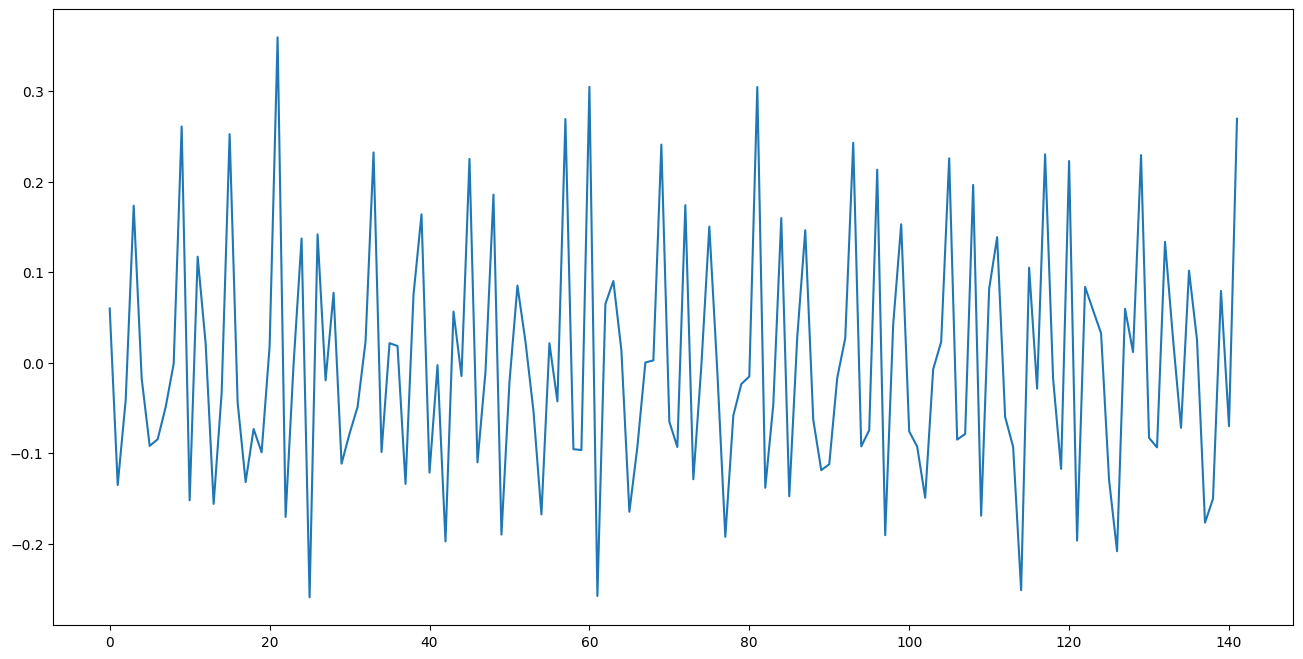

In [20]:
plt.plot(diff_airline)

Из данного графика видно, что тренда нет, сезонности также не наблюдается, поэтому можно воспользоваться простым экспоненциальным сглаживанием.

In [59]:
stat_airline_smoothing = SimpleExpSmoothing(diff_airline).fit()

In [60]:
fitted_stat = stat_airline_smoothing.predict(0, len(airlines_passengers) + 12)

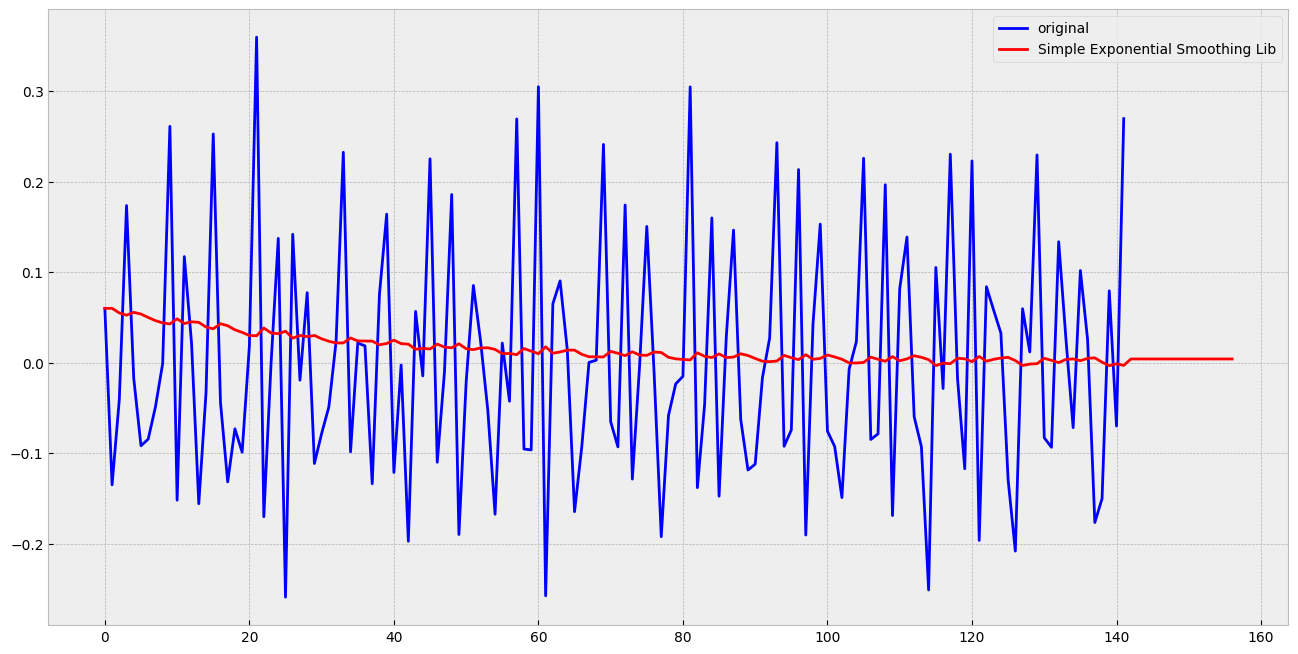

In [118]:
visualize(diff_airline, fitted_stat, 'Simple Exponential Smoothing Lib')

Библиотечный метод показал удручающие результаты, поэтому попробуем подобрать параметр alpha самостоятельно

In [135]:
result = exponential_moving_average(diff_airline, 0.8, n_pred=12)

In [136]:
result.head()

0    0.059932
1   -0.096099
2   -0.052046
3    0.128396
4    0.011642
dtype: float64

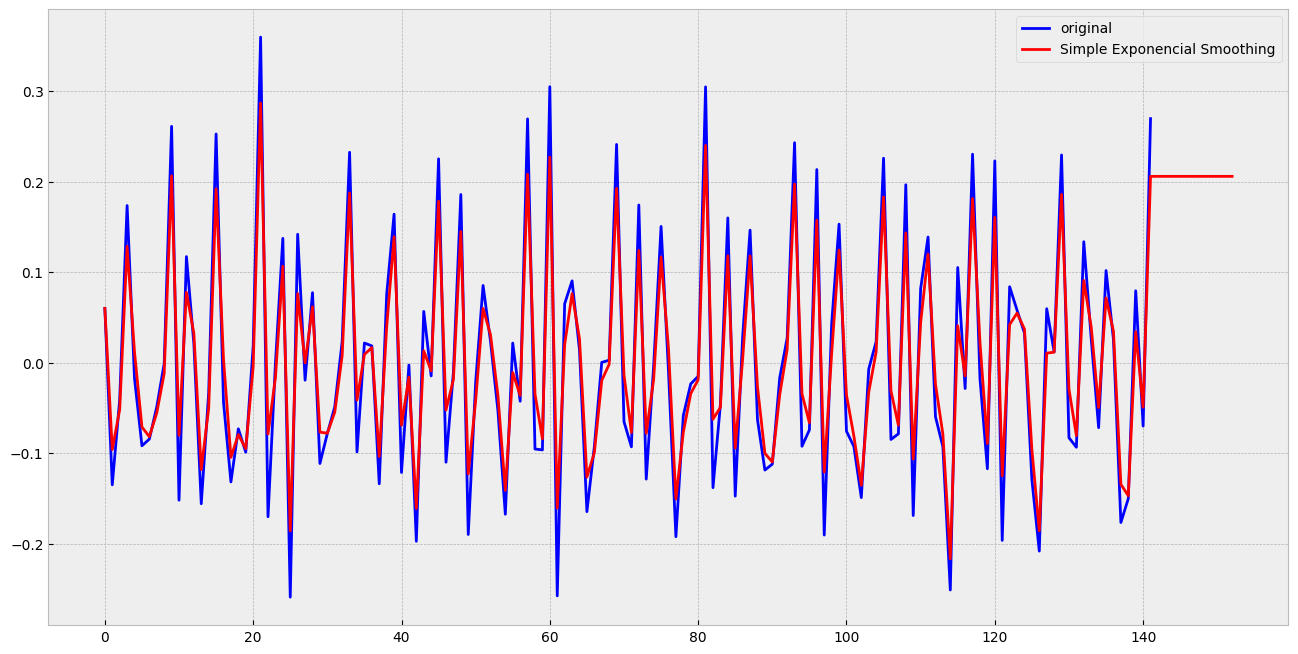

In [137]:
visualize(diff_airline, result, 'Simple Exponencial Smoothing')

Несмотря на то, что подгонка получилось неплохой, из-за того, что график очень похож на шум предсказать его с помощью сглаживаний нормально не получится, необходимо использовать более сложную модель.